In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# Load your dataset
df = pd.read_csv("/home/aditya/flask/ml/dataset/open-meteo-18.62N74.00E561m.csv")

In [3]:
# --- Clean and prepare ---
df.rename(columns={'temperature_2m (°C)': 'temperature', 'time': 'datetime'}, inplace = True)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')
df = df.reset_index(drop=True)

In [4]:
print(df.columns.tolist())

['location_id', 'datetime', 'temperature', 'relative_humidity_2m (%)', 'dew_point_2m (°C)', 'rain (mm)', 'pressure_msl (hPa)', 'surface_pressure (hPa)', 'cloud_cover (%)', 'wind_speed_10m (km/h)']


In [5]:
# --- Create lagged inputs: last 24 hours ---
for i in range(1, 25):
    df[f'temp_t-{i}'] = df['temperature'].shift(i)

In [6]:
df.head()

,location_id,datetime,temperature,relative_humidity_2m (%),dew_point_2m (°C),rain (mm),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),wind_speed_10m (km/h),...,temp_t-15,temp_t-16,temp_t-17,temp_t-18,temp_t-19,temp_t-20,temp_t-21,temp_t-22,temp_t-23,temp_t-24
0,0,2023-01-01,13.7,91,12.2,0.0,1017.3,951.9,0,2.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2023-01-01,17.4,84,14.6,0.0,1016.0,954.3,5,3.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,2023-01-01,13.6,97,13.1,0.0,1017.2,950.5,50,2.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2023-01-01,18.5,77,14.4,0.0,1015.7,961.7,10,2.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2023-01-01,14.5,98,14.1,0.0,1017.0,941.4,54,3.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# --- Create future targets: next 28 hours ---
for i in range(1, 29):
    df[f'temp_t+{i}'] = df['temperature'].shift(-i)

In [8]:
# --- Create future targets: next 28 hours ---
for i in range(1, 49):
    df[f'temp_t+{i}'] = df['temperature'].shift(-i)

In [9]:
df.head()

,location_id,datetime,temperature,relative_humidity_2m (%),dew_point_2m (°C),rain (mm),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),wind_speed_10m (km/h),...,temp_t+39,temp_t+40,temp_t+41,temp_t+42,temp_t+43,temp_t+44,temp_t+45,temp_t+46,temp_t+47,temp_t+48
0,0,2023-01-01,13.7,91,12.2,0.0,1017.3,951.9,0,2.8,...,26.2,27.2,28.4,30.6,29.2,29.6,30.4,28.4,29.8,30.7
1,2,2023-01-01,17.4,84,14.6,0.0,1016.0,954.3,5,3.3,...,27.2,28.4,30.6,29.2,29.6,30.4,28.4,29.8,30.7,30.9
2,4,2023-01-01,13.6,97,13.1,0.0,1017.2,950.5,50,2.9,...,28.4,30.6,29.2,29.6,30.4,28.4,29.8,30.7,30.9,31.3
3,3,2023-01-01,18.5,77,14.4,0.0,1015.7,961.7,10,2.8,...,30.6,29.2,29.6,30.4,28.4,29.8,30.7,30.9,31.3,30.0
4,5,2023-01-01,14.5,98,14.1,0.0,1017.0,941.4,54,3.3,...,29.2,29.6,30.4,28.4,29.8,30.7,30.9,31.3,30.0,29.8


In [10]:
# Drop rows with NaNs created by shifting
df = df.dropna()

In [11]:
print(df.isnull().sum().sum())

0


In [12]:
# --- Select input and output columns ---
input_features = [f'temp_t-{i}' for i in range(24, 0, -1)]  # temp_t-24 to temp_t-1
target_features = [f'temp_t+{i}' for i in range(1, 25)]     # temp_t+1 to temp_t+24

x = df[input_features]
y = df[target_features]

In [13]:
# --- Train-test split ---
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [14]:
# --- Train Model ---
base_model = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)
model = MultiOutputRegressor(base_model)
model.fit(x_train, y_train)

,estimator,RandomForestR...ndom_state=42)
,n_jobs,None
,n_estimators,50
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


In [19]:
# --- Predict ---
y_pred = model.predict(x_test)

In [20]:
# --- Evaluate ---
for i in range(y.shape[1]):
    mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])

    print(f"Horizon t+{i+1}:")
    print(f"  MSE : {mse:.2f}")
    print(f"  MAE : {mae:.2f}")
    print(f"  R2  : {r2:.2f}")
    print("-" * 30)

Horizon t+1:
  MSE : 2.83
  MAE : 1.28
  R2  : 0.90
------------------------------
Horizon t+2:
  MSE : 2.87
  MAE : 1.29
  R2  : 0.89
------------------------------
Horizon t+3:
  MSE : 2.93
  MAE : 1.30
  R2  : 0.89
------------------------------
Horizon t+4:
  MSE : 3.01
  MAE : 1.31
  R2  : 0.89
------------------------------
Horizon t+5:
  MSE : 3.10
  MAE : 1.33
  R2  : 0.89
------------------------------
Horizon t+6:
  MSE : 3.43
  MAE : 1.39
  R2  : 0.87
------------------------------
Horizon t+7:
  MSE : 3.64
  MAE : 1.43
  R2  : 0.87
------------------------------
Horizon t+8:
  MSE : 3.86
  MAE : 1.47
  R2  : 0.86
------------------------------
Horizon t+9:
  MSE : 4.12
  MAE : 1.51
  R2  : 0.85
------------------------------
Horizon t+10:
  MSE : 4.24
  MAE : 1.53
  R2  : 0.84
------------------------------
Horizon t+11:
  MSE : 4.57
  MAE : 1.58
  R2  : 0.83
------------------------------
Horizon t+12:
  MSE : 4.86
  MAE : 1.64
  R2  : 0.82
------------------------------
H

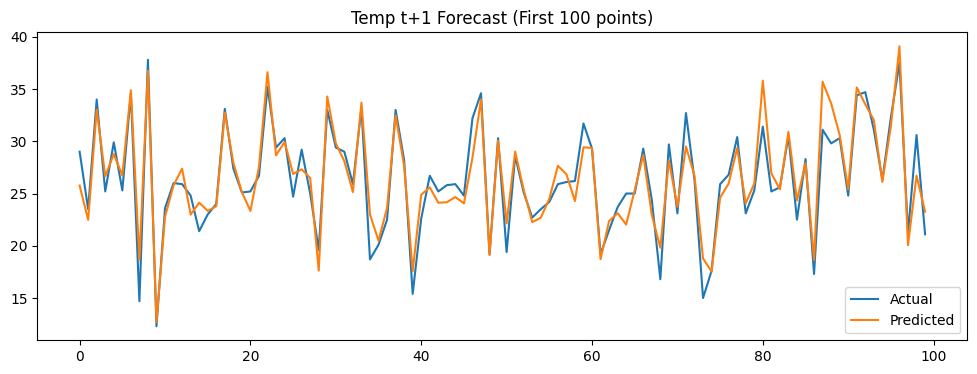

In [21]:
# --- Plot first horizon forecast ---
plt.figure(figsize=(12, 4))
plt.plot(y_test.iloc[:100, 0].values, label='Actual')
plt.plot(y_pred[:100, 0], label='Predicted')
plt.legend()
plt.title('Temp t+1 Forecast (First 100 points)')
plt.show()

In [23]:
import os

In [24]:
print(os.getcwd())

/home/aditya/flask/ml/practice


In [27]:
import joblib

joblib.dump(model, '/home/aditya/flask/ml/models/temp_24hr_model.joblib')


['/home/aditya/flask/ml/models/temp_24hr_model.joblib']